**Created by Sanskar Hasija**

**Song Popularity Prediction - 📊EDA + MODELING📊**

**18 JANUARY 2022**


# <center> SONG POPULARITY PREDICTION - 📊EDA + MODELING📊 </center>
## <center>If you find this notebook useful, support with an upvote👍</center>

# Table of Contents
<a id="toc"></a>
- [1. Introduction](#1)
- [2. Imports](#2)
- [3. Data Loading and Preperation](#3)
    - [3.1 Exploring Train Data](#3.1)
    - [3.2 Exploring Test Data](#3.2)
    - [3.3 Submission File](#3.3)
- [4. EDA](#4)
    - [4.1 Overview of Data](#4.1)
    - [4.1 Continuos and Categorical Data Distribution](#4.1)
    - [4.2 Feature Distribution of Continous Features](#4.2)
    - [4.3 Feature Distribution of Categorical Features](#4.3)
    - [4.4 Target Distribution ](#4.4)
- [WORK IN PROGRESS 🙂]()

<a id="1"></a>
# Introduction

**The competition is organised by MLspace and is the first competition of the series.**


**In this competition, you are supposed to predict the popularity of a song given features like acousticness, danceability, key, loudness, etc.**

**Submissions are evaluated on Area Under the ROC Curve (AUC)**

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="2"></a>
# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler , LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.stats import mode


from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.utils import to_categorical

from matplotlib import ticker
import time
import warnings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)
warnings.filterwarnings('ignore')

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="3"></a>
# Data Loading and Preperation

In [2]:
train = pd.read_csv("../input/song-popularity-prediction/train.csv")
test = pd.read_csv("../input/song-popularity-prediction/test.csv")
submission = pd.read_csv("../input/song-popularity-prediction/sample_submission.csv")

<a id="3.1"></a>
## Exploring Train Data

### Observations:

* There are total of ```15``` columns : ```10``` continous , ```3``` categorical ```1``` id and ```1``` target column
* ```song_popularity column``` is the target variable which is only available in the ```train``` dataset.
* Train dataset contain ```527,813``` observation with ```32,178```  missing values.
* 8 differnt rows have null values with maximum missings values in ```song_duration_ms``` column.

### Quick view of Train Data

Below is the first 5 rows of train dataset:

In [3]:
train.head()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
0,0,212990.000000,0.642286,0.856520,0.707073,0.002001,10.000000,NaN,-5.619088,0,0.082570,158.386236,4,0.734642,0
1,1,NaN,0.054866,0.733289,0.835545,0.000996,8.000000,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1
2,2,193213.000000,NaN,0.188387,0.783524,-0.002694,5.000000,0.170499,-4.951759,0,0.052282,178.685791,3,0.425536,0
3,3,249893.000000,0.488660,0.585234,0.552685,0.000608,0.000000,0.094805,-7.893694,0,0.035618,128.715630,3,0.453597,0
4,4,165969.000000,0.493017,NaN,0.740982,0.002033,10.000000,0.094891,-2.684095,0,0.050746,121.928157,4,0.741311,0


In [4]:
print(f'\033[92mNumber of rows in train data: {train.shape[0]}')
print(f'\033[94mNumber of columns in train data: {train.shape[1]}')
print(f'\033[91mNumber of values in train data: {train.count().sum()}')
print(f'\033[91mNumber missing values in train data: {sum(train.isna().sum())}')

Number of rows in train data: 40000
Number of columns in train data: 15
Number of values in train data: 567813
Number missing values in train data: 32187


### Column Wise missing values

In [5]:
print(train.isna().sum().sort_values(ascending = False))

song_duration_ms    4101
liveness            4086
key                 4065
danceability        4026
acousticness        3992
instrumentalness    3985
energy              3975
loudness            3957
id                     0
audio_mode             0
speechiness            0
tempo                  0
time_signature         0
audio_valence          0
song_popularity        0
dtype: int64


### Basic statistics of training data

In [6]:
train.describe()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
count,40000.000000,35899.000000,36008.000000,35974.000000,36025.000000,36015.000000,35935.000000,35914.000000,36043.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,19999.500000,193165.847572,0.276404,0.570951,0.683932,0.036527,5.042605,0.198514,-7.407596,0.321150,0.094107,116.562815,3.394375,0.580645,0.364400
std,11547.149720,45822.127679,0.297928,0.190010,0.212662,0.150024,3.372728,0.151670,3.877198,0.466924,0.083591,26.167911,0.524405,0.237351,0.481268
min,0.000000,25658.000000,-0.013551,0.043961,-0.001682,-0.004398,0.000000,0.027843,-32.117911,0.000000,0.015065,62.055779,2.000000,0.013398,0.000000
25%,9999.750000,166254.500000,0.039618,0.424760,0.539276,0.000941,2.000000,0.111796,-9.578139,0.000000,0.038500,96.995309,3.000000,0.398669,0.000000
50%,19999.500000,186660.000000,0.140532,0.608234,0.704453,0.001974,5.000000,0.135945,-6.345413,0.000000,0.055881,113.795959,3.000000,0.598827,0.000000
75%,29999.250000,215116.000000,0.482499,0.718464,0.870503,0.003225,8.000000,0.212842,-4.620711,1.000000,0.118842,128.517383,4.000000,0.759635,1.000000
max,39999.000000,491671.000000,1.065284,0.957131,1.039741,1.075415,11.000000,1.065298,-0.877346,1.000000,0.560748,219.163578,5.000000,1.022558,1.000000


<a id="3.2"></a>
## Exploring Test Data

### Observations:

* There are total of ```14``` columns : ```10``` continous , ```3``` categorical ```1``` id in ```test``` dataset
* Train dataset contain ```122,038``` observation with ```7962```  missing values.
* 8 differnt rows have null values with maximum missings values in ```energy``` column.

### Quick view of Test Data

In [7]:
test.head()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,0,308523.000000,0.019845,NaN,0.908939,0.001438,NaN,0.112832,-8.890172,0,0.082714,126.129304,4,0.399620
1,1,200011.000000,0.070119,0.731256,0.444655,0.002020,10.000000,0.139040,-6.301214,0,0.061685,86.448149,3,0.499424
2,2,279758.000000,0.810637,0.568858,0.125466,0.898841,0.000000,0.226614,-11.542478,0,0.041868,99.544351,3,0.564951
3,3,249197.000000,NaN,0.871789,0.557342,0.000715,4.000000,0.325391,-7.905546,1,0.046815,123.063854,4,0.906485
4,4,NaN,0.765568,0.624687,0.710794,0.000346,8.000000,0.308284,NaN,0,0.129284,88.703121,3,0.935571


In [8]:
print(f'\033[92mNumber of rows in test data: {test.shape[0]}')
print(f'\033[94mNumber of columns in test data: {test.shape[1]}')
print(f'\033[91mNumber of values in train data: {test.count().sum()}')
print(f'\033[91mNo of rows with missing values  in test data: {sum(test.isna().sum())}')

Number of rows in test data: 10000
Number of columns in test data: 14
Number of values in train data: 132038
No of rows with missing values  in test data: 7962


### Column Wise missing values

In [9]:
print((test.isna().sum().sort_values(ascending = False)))

energy              1055
loudness            1026
liveness            1006
instrumentalness    1000
key                  992
danceability         976
song_duration_ms     957
acousticness         950
id                     0
audio_mode             0
speechiness            0
tempo                  0
time_signature         0
audio_valence          0
dtype: int64


### Basic statistics of test data

In [10]:
test.describe()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
count,10000.000000,9043.000000,9050.000000,9024.000000,8945.000000,9000.000000,9008.000000,8994.000000,8974.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.500000,193091.108813,0.280280,0.569817,0.683552,0.036588,5.012544,0.196379,-7.422145,0.323800,0.094242,116.460635,3.391800,0.576109
std,2886.895680,46502.319884,0.299971,0.190177,0.212561,0.151470,3.387481,0.149440,3.902743,0.467948,0.084294,26.320082,0.529075,0.236501
min,0.000000,25377.000000,-0.013585,0.064548,0.020959,-0.003344,0.000000,0.034516,-29.887298,0.000000,0.017554,60.702888,2.000000,0.017450
25%,2499.750000,166689.000000,0.042181,0.426734,0.541975,0.000930,2.000000,0.111599,-9.654517,0.000000,0.038282,96.951325,3.000000,0.395860
50%,4999.500000,186196.000000,0.141564,0.605759,0.700278,0.001964,5.000000,0.135997,-6.346205,0.000000,0.055208,113.258381,3.000000,0.588477
75%,7499.250000,215059.000000,0.493003,0.715491,0.870670,0.003165,8.000000,0.208563,-4.605297,1.000000,0.118976,128.020862,4.000000,0.755265
max,9999.000000,448558.000000,1.046311,0.946831,1.031383,1.020970,11.000000,1.003777,-0.879306,1.000000,0.526199,213.922252,5.000000,1.013865


<a id="3.3"></a>
## Submission File

### Quick view of Submission File

In [11]:
submission.head()

,id,song_popularity
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="4"></a>
# EDA

<a id="4.1"></a>
## Overview of Data

In [12]:
train.drop(["id"] , axis = 1 , inplace = True)
test.drop(["id"] , axis = 1 , inplace = True)
TARGET = 'song_popularity'
FEATURES = [col for col in train.columns if col not in ['id', TARGET]]
RANDOM_STATE = 12 

In [13]:
train.iloc[:, :-1].describe().T.sort_values(by='std' , ascending = False)\
                     .style.background_gradient(cmap='GnBu')\
                     .bar(subset=["max"], color='#BB0000')\
                     .bar(subset=["mean",], color='green')

,count,mean,std,min,25%,50%,75%,max
song_duration_ms,35899.000000,193165.847572,45822.127679,25658.000000,166254.500000,186660.000000,215116.000000,491671.000000
tempo,40000.000000,116.562815,26.167911,62.055779,96.995309,113.795959,128.517383,219.163578
loudness,36043.000000,-7.407596,3.877198,-32.117911,-9.578139,-6.345413,-4.620711,-0.877346
key,35935.000000,5.042605,3.372728,0.000000,2.000000,5.000000,8.000000,11.000000
time_signature,40000.000000,3.394375,0.524405,2.000000,3.000000,3.000000,4.000000,5.000000
audio_mode,40000.000000,0.321150,0.466924,0.000000,0.000000,0.000000,1.000000,1.000000
acousticness,36008.000000,0.276404,0.297928,-0.013551,0.039618,0.140532,0.482499,1.065284
audio_valence,40000.000000,0.580645,0.237351,0.013398,0.398669,0.598827,0.759635,1.022558
energy,36025.000000,0.683932,0.212662,-0.001682,0.539276,0.704453,0.870503,1.039741
danceability,35974.000000,0.570951,0.190010,0.043961,0.424760,0.608234,0.718464,0.957131


<a id="4.2"></a>
## Continuos and Categorical Data Distribution

Total number of features: 13
Number of categorical features: 3
Number of continuos features: 10


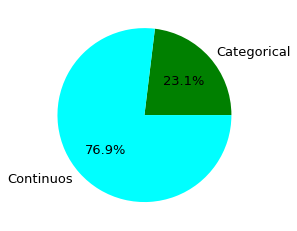

In [14]:
df = pd.concat([train[FEATURES], test[FEATURES]], axis=0)

cat_features = [col for col in FEATURES if df[col].nunique() < 15]
cont_features = [col for col in FEATURES if df[col].nunique() >= 15]

del df
print(f'Total number of features: {len(FEATURES)}')
print(f'\033[92mNumber of categorical features: {len(cat_features)}')
print(f'\033[96mNumber of continuos features: {len(cont_features)}')

plt.pie([len(cat_features), len(cont_features)], 
        labels=['Categorical', 'Continuos'],
        colors=['green', 'cyan'],
        textprops={'fontsize': 13},
        autopct='%1.1f%%')
plt.show()

<a id="4.3"></a>
## Feature Distribution of Continous Features

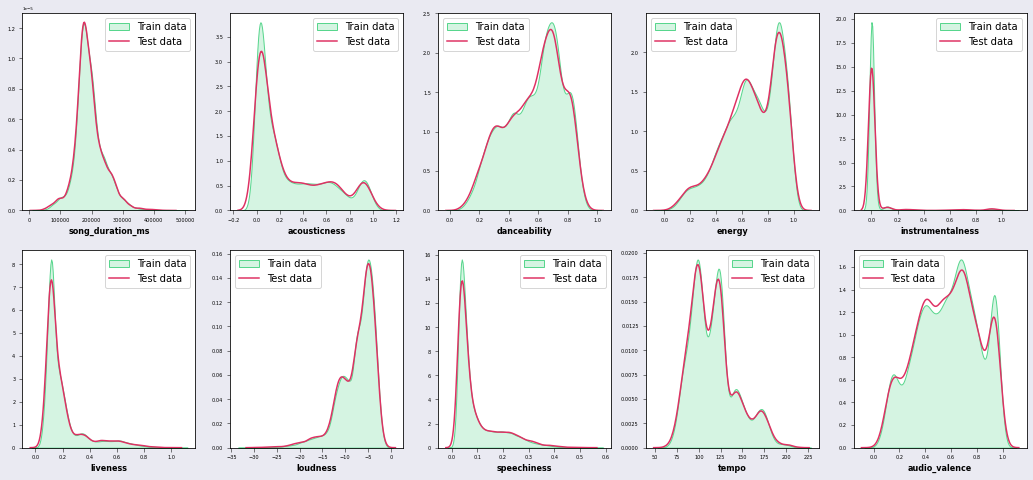

In [15]:
ncols = 5
nrows = int(len(cont_features) / ncols + (len(FEATURES) % ncols > 0))-1

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 8), facecolor='#EAEAF2')

for r in range(nrows):
    for c in range(ncols):
        col = cont_features[r*ncols+c]
        sns.kdeplot(x=train[col], ax=axes[r, c], color='#58D68D', label='Train data' , fill =True)
        sns.kdeplot(x=test[col], ax=axes[r, c], color='#DE3163', label='Test data')
        axes[r,c].legend()
        axes[r, c].set_ylabel('')
        axes[r, c].set_xlabel(col, fontsize=8, fontweight='bold')
        axes[r, c].tick_params(labelsize=5, width=0.5)
        axes[r, c].xaxis.offsetText.set_fontsize(4)
        axes[r, c].yaxis.offsetText.set_fontsize(4)
plt.show()

<a id="4.4"></a>
## Feature Distribution of Categorical Features

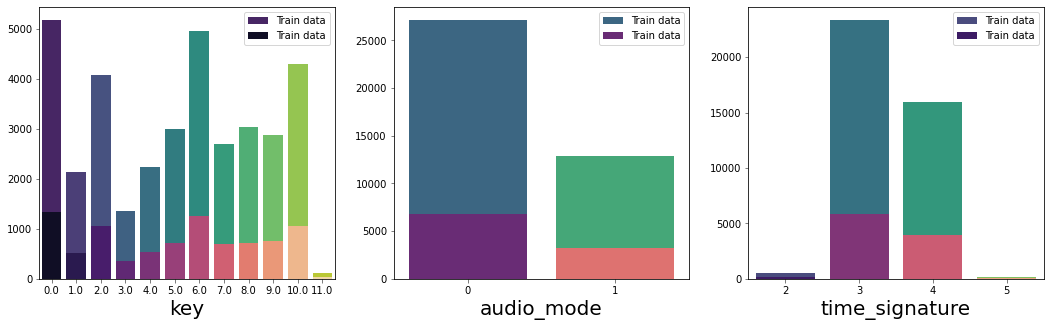

In [16]:
if len(cat_features) == 0 :
    print("No Categorical features")
else:
    ncols = 3
    nrows = 1

    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 5))
    for r in range(nrows):
        for c in range(ncols):
            col = cat_features[c]
            sns.countplot(train[col],ax = axes[c] ,palette = "viridis", label='Train data')
            sns.countplot(test[col],ax = axes[c] ,palette = "magma", label='Train data')
            axes[c].legend()
            axes[c].set_ylabel('')
            axes[c].set_xlabel(col, fontsize=20)
            axes[c].tick_params(labelsize=10, width=0.5)
            axes[c].xaxis.offsetText.set_fontsize(4)
            axes[c].yaxis.offsetText.set_fontsize(4)
    plt.show()

<a id="4.5"></a>
## Target Distribution

In [17]:
target_df = pd.DataFrame(train[TARGET].value_counts()).reset_index()
target_df.columns = [TARGET, 'count']
fig = px.bar(data_frame =target_df, 
             x = TARGET,
             y = 'count' , 
             color = "count",
             color_continuous_scale="Emrld") 
print("\033[94mPercentage of song_popularity = 0: {:.2f} %".format(target_df["count"][0] *100 / train.shape[0]))
print("\033[94mPercentage of song_popularity = 1: {:.2f} %".format(target_df["count"][1]* 100 / train.shape[0]))
fig.show()

Percentage of song_popularity = 0: 63.56 %
Percentage of song_popularity = 1: 36.44 %


<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

## <center>WORK IN PROGRESS 🙂</center>